# __Data visualisation__

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

import pylab
pylab.rcParams['figure.figsize'] = (7, 4)

In [2]:
df = pd.read_pickle('../data/marginal_emissions_impute.pkl')
df.head()

,t CO2-e / MWh
2018-06-01 03:55:00,0.912643
2018-06-01 03:50:00,0.912643
2018-06-01 03:45:00,0.912643
2018-06-01 03:40:00,0.912643
2018-06-01 03:35:00,0.912643


In [3]:
df.shape

(938016, 1)

In [4]:
df.isnull().any()

t CO2-e / MWh    False
dtype: bool

## __Plotting each 5 min interval__

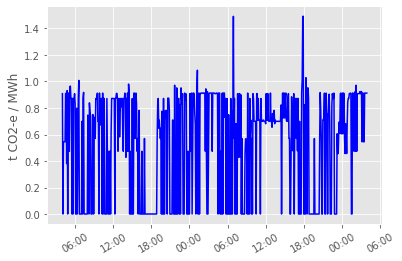

In [5]:
import matplotlib.dates as mdates

plt.style.use('ggplot')
fig = sns.lineplot(df.index[:576], df['t CO2-e / MWh'].iloc[:576], color='blue')
fig.set_ylabel("t CO2-e / MWh")


date_format = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(date_format)

for i in fig.get_xticklabels():
    i.set_rotation(30)

sns.set_style("whitegrid")

#pip install --upgrade numpy pandas matplotlib seaborn jupyterlab

## __Plotting grouped time intervals__

In [6]:
df_resample = df.resample("M").mean() 
#check out 'DateOffset objects here: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects'
df_resample.head()

,t CO2-e / MWh
2009-07-31,0.712169
2009-08-31,0.746410
2009-09-30,0.714135
2009-10-31,0.642606
2009-11-30,0.638639


In [7]:
"""Convenience method for frequency conversion and resampling of time series. Object must have a datetime-like index
(DatetimeIndex, PeriodIndex, or TimedeltaIndex), or pass datetime-like values to the on or level keyword"""

'Convenience method for frequency conversion and resampling of time series. Object must have a datetime-like index\n(DatetimeIndex, PeriodIndex, or TimedeltaIndex), or pass datetime-like values to the on or level keyword'

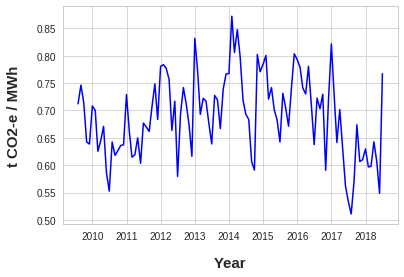

In [8]:
fig = plt.plot_date(df_resample.index, df_resample['t CO2-e / MWh'], linestyle='solid', marker=None, color='blue')

plt.xlabel("Year", labelpad=15, fontsize=15, fontweight='bold')
plt.ylabel("t CO2-e / MWh", labelpad=15, fontsize=15, fontweight='bold')

sns.set_style('whitegrid')
plt.style.use('seaborn')

## __Anything more than randomness? -> decompose__

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

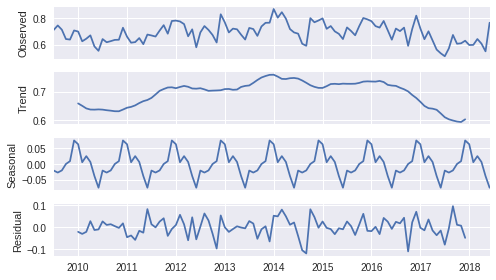

In [10]:
df_decomposed = seasonal_decompose(df_resample['t CO2-e / MWh'], model='additive') #sketch on whiteboard
pylab.rcParams['figure.figsize'] = (7, 4)
df_decomposed.plot();

## __Anything more than randomness? -> check for random walk behaviour__

<br/>
$y_t=y_{t-1}+\epsilon_t$
<br/>
<br/>

In [11]:
import numpy as np

from random import seed
from random import random
from matplotlib import pyplot

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf

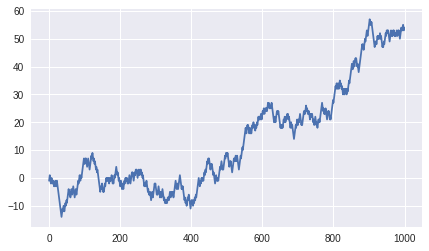

In [12]:
seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)
for i in range(1, 1000):
	movement = -1 if random() < 0.5 else 1
	value = random_walk[i-1] + movement
	random_walk.append(value)
pyplot.plot(random_walk)
pyplot.show()

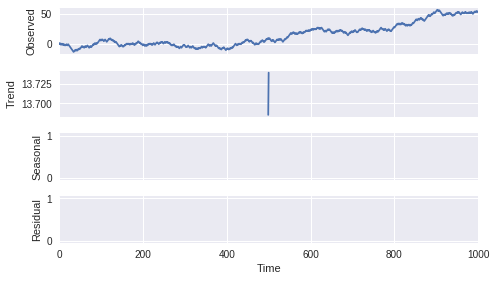

In [13]:
test = seasonal_decompose(random_walk, freq=998)
pylab.rcParams['figure.figsize'] = (7, 4)
test.plot();

## __Anything more than randomness? -> Autocorrelation of raw data__

Autocorrelation:

${\displaystyle \rho_k = \frac {\sum\limits_{t=1}^{n-k} (y_t - \bar{y})(y_{t+k}-\bar{y})} {\sum\limits_{t=1}^{n} (y_t - \bar{y})^2}}$

In [13]:

#sketch whiteboard


In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### __Random walk acf__

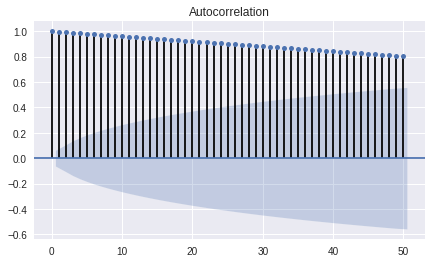

In [15]:
plot_acf(random_walk, lags=50);

### __Marginal emissions acf__

In [16]:
import datetime as dt

df_acf = df[df.index > dt.datetime(2017,1,1,0,0,0)]
print(df.index.min())
df_acf.index.max()

2009-07-01 04:00:00


Timestamp('2018-06-01 03:55:00')

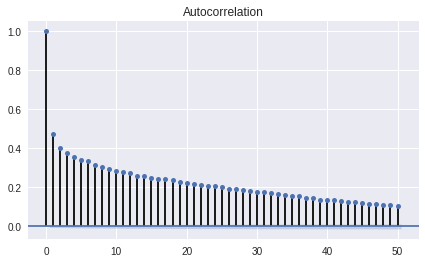

In [17]:
plot_acf(df_acf, lags=50);

## __Anything more than randomness? -> Autocorrelation of differenced data__

### __Differenced random walk acf__

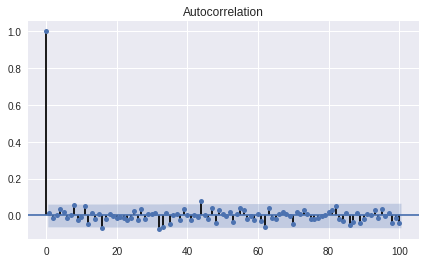

In [18]:
# take difference
diff = list()
for i in range(1, len(random_walk)):
	value = random_walk[i] - random_walk[i - 1]
	diff.append(value)
    
plot_acf(diff, lags=100);

### __Differenced marginal emissions acf__

In [19]:
df_acf['differenced'] = df_acf["t CO2-e / MWh"] - df_acf["t CO2-e / MWh"].shift(1)
df_acf.head(7)

,t CO2-e / MWh,differenced
2018-06-01 03:55:00,0.912643,NaN
2018-06-01 03:50:00,0.912643,0.000000
2018-06-01 03:45:00,0.912643,0.000000
2018-06-01 03:40:00,0.912643,0.000000
2018-06-01 03:35:00,0.912643,0.000000
2018-06-01 03:30:00,0.544686,-0.367957
2018-06-01 03:25:00,0.544686,0.000000


In [20]:
df_acf[df_acf.differenced.isna()]

,t CO2-e / MWh,differenced
2018-06-01 03:55:00,0.912643,NaN


In [21]:
df_acf.dropna(inplace=True)
df_acf[df_acf.differenced.isna()]

,t CO2-e / MWh,differenced


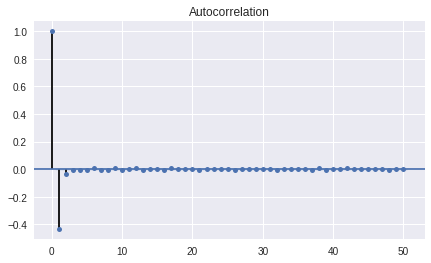

In [22]:
plot_acf(df_acf.differenced, lags=50);

### __Excursion: Partial autocorrelation__

In [71]:

#sketch on whiteboard


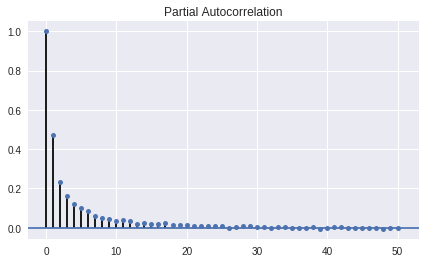

In [23]:
plot_pacf(df_acf['t CO2-e / MWh'], lags=50);

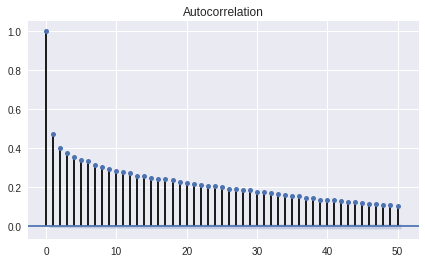

In [24]:
plot_acf(df_acf['t CO2-e / MWh'], lags=50);

## __Selection of relevant time features for training__

In [25]:
group_year = df.groupby(df.index.year).mean()
group_quarter = df.groupby(df.index.quarter).mean()
group_month = df.groupby(df.index.month).mean()
group_week = df.groupby(df.index.week).mean()
group_weekday = df.groupby(df.index.weekday).mean()
group_day = df.groupby(df.index.day).mean()
group_hour = df.groupby(df.index.hour).mean()
group_minute = df.groupby(df.index.minute).mean()

#quarter: Quarter of the date: Jan-Mar = 1, Apr-Jun = 2, etc.

In [26]:
time_periods = {"year":group_year,"quarter":group_quarter, "month":group_month, "week":group_week,\
                "weekday":group_weekday,"day":group_day, "hour":group_hour, "minute":group_minute}

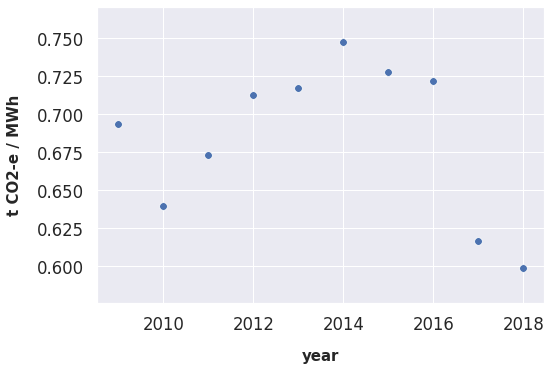

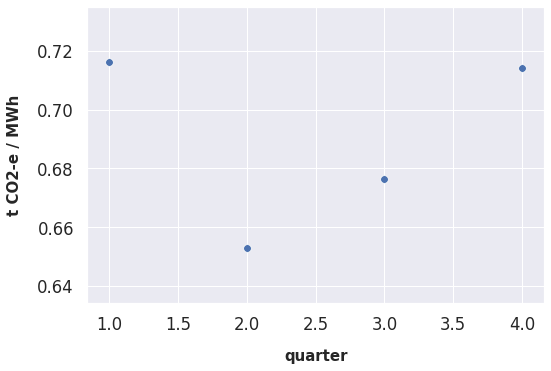

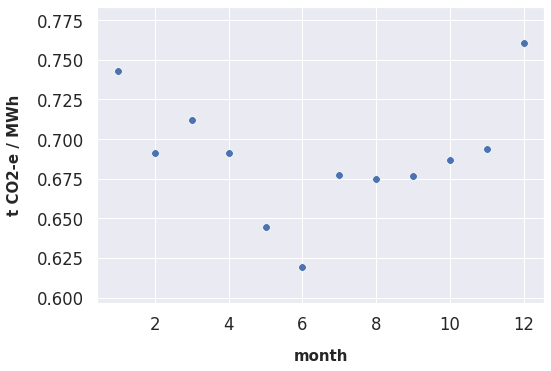

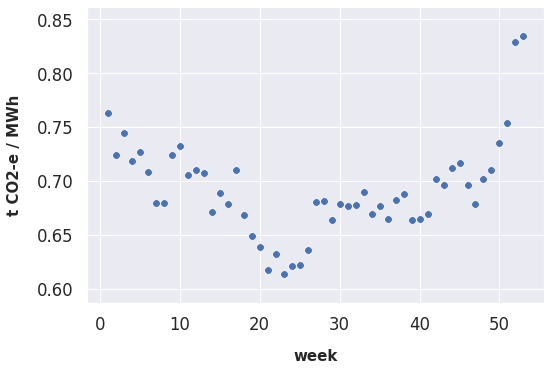

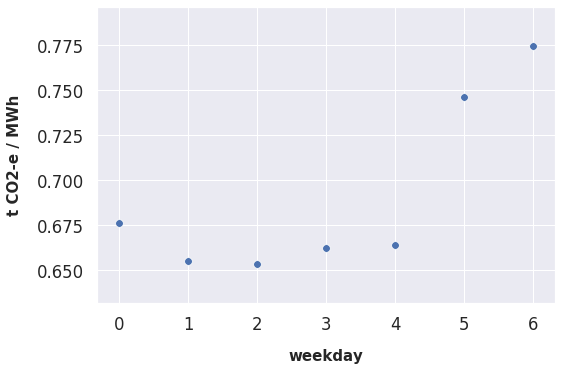

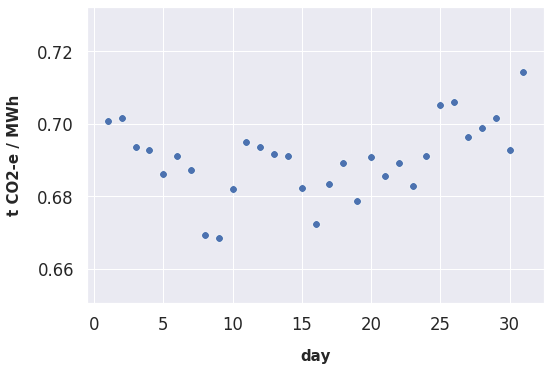

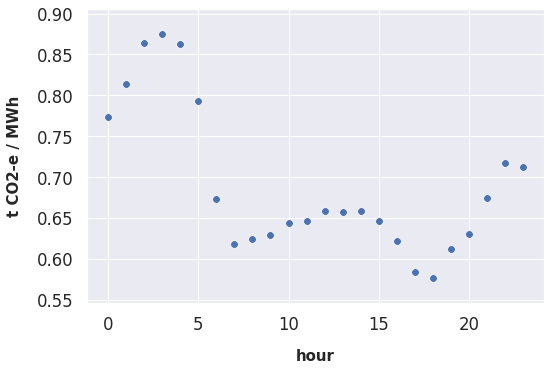

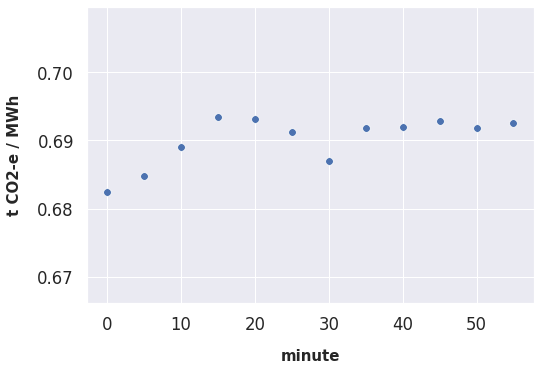

<Figure size 576x396 with 0 Axes>

In [30]:
for i in time_periods:
    fig = sns.scatterplot(time_periods[i].index, time_periods[i]['t CO2-e / MWh'], s=60)
    
    fig.set_xlabel(i, labelpad=15, fontsize=15, fontweight='bold')
    fig.set_ylabel("t CO2-e / MWh", labelpad=15, fontsize=15, fontweight='bold')
    
    plt.style.use('seaborn')
    sns.set(font_scale=1.5)
    plt.tight_layout()
    
    plt.figure()